In [1]:
!python --version

import cv2
import pytesseract

import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bisect import bisect


Python 3.7.9


In [2]:
def myround(x, base=10):
    return base * round(x/base)

def myceil(x, base=10):
    return base * np.ceil(x/base)

In [3]:
ipath =  "/Users/zastrow/Documents/codecamp/receipt-ocr/img_data/"
opath =  "/Users/zastrow/Documents/codecamp/receipt-ocr/output/"

In [6]:
filename = os.path.join(ipath, "receipt3_1.png")
img = cv2.imread(filename)

hh, ww, cc = img.shape
#print(hh, ww, cc)

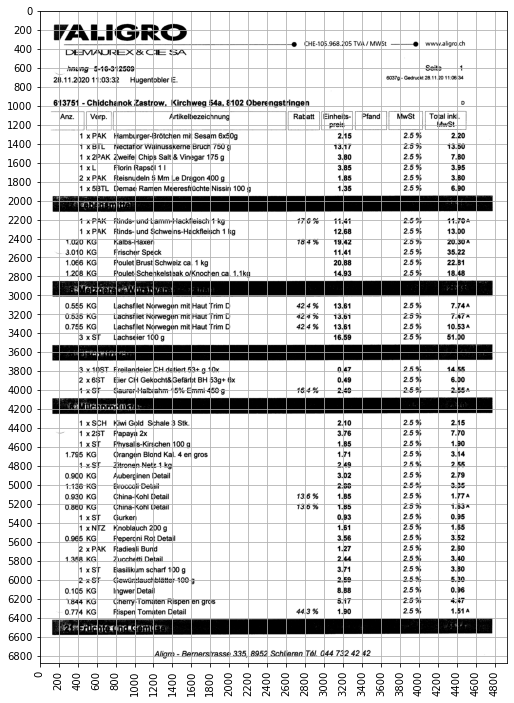

In [7]:
fig1, ax1 = plt.subplots(figsize=(16, 12))
ax1.imshow(img)

xticks = range(0, int( myceil(ww, base=1000) ), 200)
yticks = range(0, int( myceil(hh, base=1000) ), 200)

ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_xticklabels(xticks, rotation = 90)
ax1.grid(which="both", axis="both")


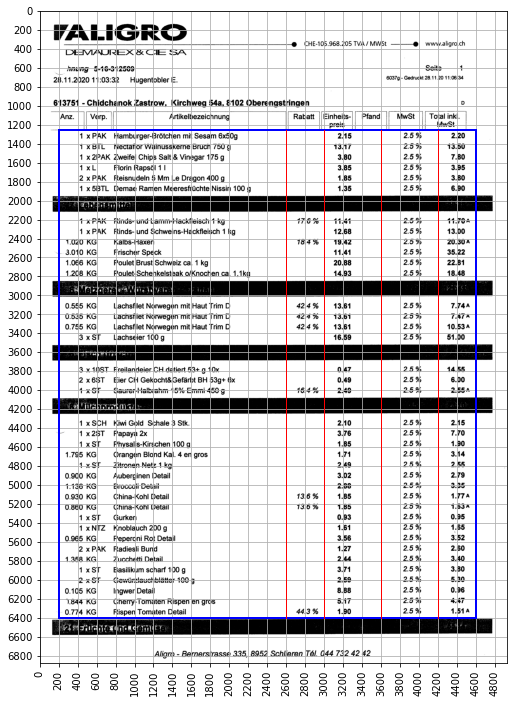

In [8]:
#input
y1, y2, x1, x2 = 1250, 6400, 200, 4600 #top, bottom, left, right
vlines = [2600, 3000, 3600, 4200]
conf_level = 35

#replot fig1 with ROI
fig1, ax1 = plt.subplots(figsize=(16, 12))
ax1.imshow(img)

xticks = range(0, int( myceil(ww, base=1000) ), 200)
yticks = range(0, int( myceil(hh, base=1000) ), 200)

ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_xticklabels(xticks, rotation = 90)
ax1.grid(which="both", axis="both")

#draw ROI
ax1.plot([x1, x2], [y1, y1], 'b-', linewidth=2)
ax1.plot([x1, x2], [y2, y2], 'b-', linewidth=2)
ax1.plot([x1, x1], [y1, y2], 'b-', linewidth=2)
ax1.plot([x2, x2], [y1, y2], 'b-', linewidth=2)

#draw columns
for vline in vlines:
    ax1.plot([vline, vline], [y1, y2], 'r-', linewidth=1)
    ax1.plot([vline, vline], [y1, y2], 'r-', linewidth=1)

In [9]:
config_option = "--psm 1"
d = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT, lang="eng", config=config_option)
#print(d.keys())

df = pd.DataFrame(data=d)
df.head(15)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,4928,6882,-1,
1,2,1,1,0,0,0,536,147,1010,178,-1,
2,3,1,1,1,0,0,151,147,1395,178,-1,
3,4,1,1,1,1,0,536,147,1010,178,-1,
4,5,1,1,1,1,1,536,153,144,168,88,L
5,5,1,1,1,1,2,698,153,68,167,98,I
6,5,1,1,1,1,3,786,147,261,178,85,G
7,5,1,1,1,1,4,1067,147,479,178,79,R0
8,2,1,2,0,0,0,272,412,1270,64,-1,
9,3,1,2,1,0,0,272,412,1270,64,-1,


In [10]:
#select just text objects ("level"==5) within ROI

idxroi = df[ (df["top"] > y1) & \
             (df["top"] < y2) & \
             (df["left"] > x1)& \
             (df["left"] < x2)& \
             (df["level"] == 5)].index


In [11]:
#add bb of detected texts within ROI
imgbb = img.copy()

linewidth = 2
r, g, b = 0, 255, 0

for idx in (list(idxroi)):
    (x, y, w, h) = (df["left"][idx], df["top"][idx], df["width"][idx], df["height"][idx])
    imgbb = cv2.rectangle(imgbb, (x, y), (x+w, y+h), (r, g, b), linewidth)


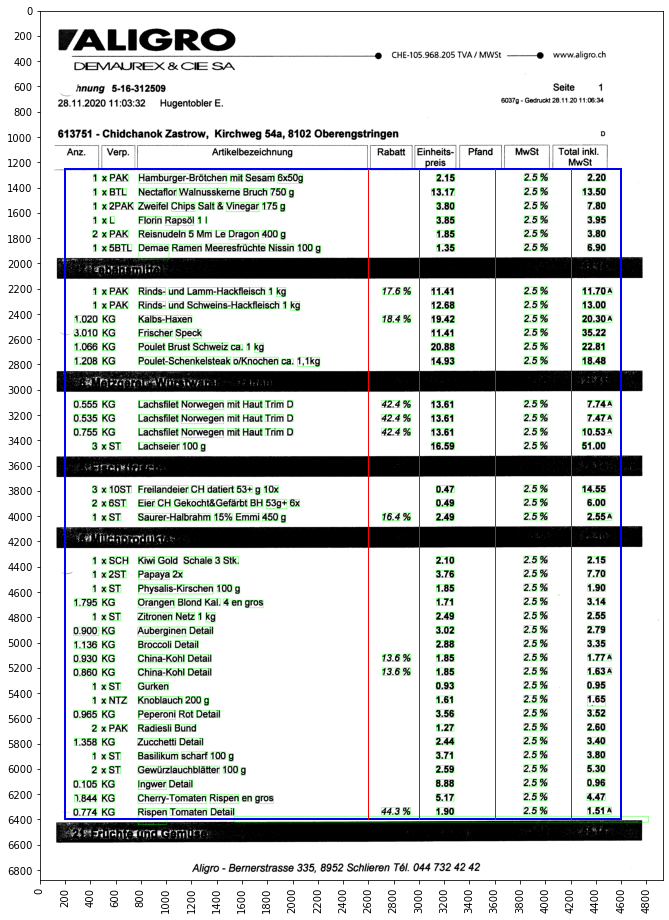

In [12]:
#draw detected text bbs

fig, ax = plt.subplots(figsize=(20, 16))
#axs[0].imshow(img);
ax.imshow(imgbb);

#draw ROI
ax.plot([x1, x2], [y1, y1], 'b-', linewidth=2);
ax.plot([x1, x2], [y2, y2], 'b-', linewidth=2);
ax.plot([x1, x1], [y1, y2], 'b-', linewidth=2);
ax.plot([x2, x2], [y1, y2], 'b-', linewidth=2);

#draw columns
for vline in vlines:
    ax.plot([vline, vline], [y1, y2], 'r-', linewidth=1);
    ax.plot([vline, vline], [y1, y2], 'r-', linewidth=1);

ax.set_xticks(xticks);
ax.set_yticks(yticks);
ax.set_xticklabels(xticks, rotation = 90);
#axs.grid(which="both", axis="both")

In [25]:
subset = df.iloc[idxroi].reset_index()
subset.head(10)

,index,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,76,5,1,9,1,1,1,422,1298,23,57,99,1
1,77,5,1,9,1,1,2,491,1312,37,43,96,x
2,78,5,1,9,1,1,3,553,1297,145,58,94,PAK
3,79,5,1,9,1,1,4,782,1296,696,75,70,Hamburger-Brbtchen
4,80,5,1,9,1,1,5,1506,1297,97,59,90,mit
5,81,5,1,9,1,1,6,1627,1296,228,60,90,Sesam
6,82,5,1,9,1,1,7,1881,1296,198,75,81,6x509
7,83,5,1,9,1,1,8,3136,1297,144,59,92,2.15
8,84,5,1,9,1,1,9,3829,1293,104,58,91,2.5
9,85,5,1,9,1,1,10,3958,1291,59,61,91,%


In [26]:
# use ui column seperators to bin detected texts into columns
seplines = sorted( vlines + [x1, x2] )
ncols = len(seplines) - 1
col = [bisect(seplines, subset["left"].iloc[i]) for i in range(0, len(subset))]

#add/remove ["column", "diff"]/["block_num","par_num"] fields to/from df
subset["column"] = col
subset.drop(["block_num", "par_num"], axis=1, inplace=True)

subset["diff"] = subset["word_num"].diff()

subset.head(10)

,index,level,page_num,line_num,word_num,left,top,width,height,conf,text,column,diff
0,76,5,1,1,1,422,1298,23,57,99,1,1,NaN
1,77,5,1,1,2,491,1312,37,43,96,x,1,1.0
2,78,5,1,1,3,553,1297,145,58,94,PAK,1,1.0
3,79,5,1,1,4,782,1296,696,75,70,Hamburger-Brbtchen,1,1.0
4,80,5,1,1,5,1506,1297,97,59,90,mit,1,1.0
5,81,5,1,1,6,1627,1296,228,60,90,Sesam,1,1.0
6,82,5,1,1,7,1881,1296,198,75,81,6x509,1,1.0
7,83,5,1,1,8,3136,1297,144,59,92,2.15,3,1.0
8,84,5,1,1,9,3829,1293,104,58,91,2.5,4,1.0
9,85,5,1,1,10,3958,1291,59,61,91,%,4,1.0


In [27]:
istarts = subset[subset["diff"]<0].index.values
#istarts = subset[subset["word_num"]==1].index.values
iends = np.append(istarts[1:], len(subset)) #already +1 to indices for slicing

if istarts[0] > 0:
    iends   = np.append(istarts[0], iends)
    istarts = np.append(0, istarts)
    
with open(os.path.join(opath, "receipt3_1.csv"), "w") as outfile:
    writer = csv.writer(outfile)
    
    for idxs, idxe in zip(istarts, iends):
        line = subset.iloc[idxs:idxe]
        columns = line["column"].unique()
        
        csvline = [' '] * ncols
        for column in columns:
            ci = column-1 #index
            ctext = "{}".format( ' '.join(line[line["column"]==column]["text"]) )
            csvline[ci] = ctext
        
        print(csvline)
        writer.writerow(csvline)
outfile.close()

['1 x PAK Hamburger-Brbtchen mit Sesam 6x509', ' ', '2.15', '2.5 %', '2.20']
['1 x BTL Nectaﬂor Walnusskerne Bruch 750 g', ' ', '13.17', '2.5 %', '13.50']
['1 x 2PAK Zweifel Chips Salt & Vinegar 175 g', ' ', '3.80', '2.5 %', '7.80']
['1 x L Florin Rapsél 1 |', ' ', '3.85', '2.5 %', '3.95']
['2 x PAK Reisnudeln 5 Mm Le Dragon 400 g', ' ', '1.85', '2.5 %', '3.80']
['1 x 5BTL Demae Ramen Meeresfriichte Nissin 100 g', ' ', '1.35', '2.5 %', '6.90']
['1 x PAK Rinds— und Lamm-Hackﬂeisch 1 kg', '17.6 %', '11.41', '2.5 %', '11.70A']
['1 x PAK Rinds- und Schweins-Hackﬂeisch 1 kg', ' ', '12.68', '2.5 %', '13.00']
['1.020 KG Kalbs-Haxen', '18.4 %', '19.42', '2.5 %', '20.30A']
['3.010 KG Frischer Speck', ' ', '11.41', '2.5 %', '35.22']
['1.066 KG Poulet Brust Schweiz ca. 1 kg', ' ', '20.88', '2.5 %', '22.81']
['1.208 KG Poulet-Schenkelsteak o/Knochen ca. 1,1kg', ' ', '14.93', '2.5 %', '18.48']
['0.555 KG Lachsﬁlet Norwegen mit Haut Trim D', '42.4 %', '13.61', '2.5 %', '7.74A']
['0.535 KG Lachsﬁlet 